In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize, rotate
import math

In [2]:
images_path = "./pictures/"
masks_path = "./groupR_masks/"
path = "131_197_260"

def prepare_im(im_id):
    prefix = 'PAT'
    extension = ".png"
    im = plt.imread(f"{images_path}{prefix}_{im_id}{extension}")
    im = resize(im, (im.shape[0] // 4, im.shape[1] // 4), anti_aliasing=True)
    
    gt = im = plt.imread(f"{masks_path}{prefix}_{im_id}_mask{extension}")
    gt = resize(gt, (gt.shape[0] // 4, gt.shape[1] // 4), anti_aliasing=False) #Setting it to True creates values that are not 0 or 1
    
    return im, gt

im, gt = prepare_im(path)

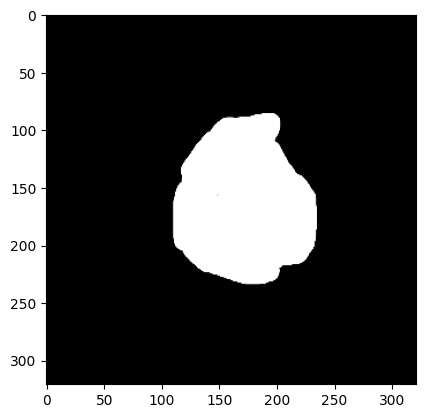

In [3]:
plt.imshow(gt, cmap="gray")

In [4]:
def get_cropped(img, padding=0):
    """Crops the image to bounding boxes with given padding."""
    # Find coordinates of non-zero pixels
    cords = np.where(img != 0)
    # Determine the bounds of the non-zero pixels
    x_min, x_max = np.min(cords[0]), np.max(cords[0])
    y_min, y_max = np.min(cords[1]), np.max(cords[1])
    # Apply padding, ensuring we do not go out of image bounds
    x_min = max(x_min - padding, 0)
    x_max = min(x_max + padding, img.shape[0] - 1)
    y_min = max(y_min - padding, 0)
    y_max = min(y_max + padding, img.shape[1] - 1)
    # Crop the image
    cropped_img = img[x_min:x_max+1, y_min:y_max+1]
    return cropped_img

def flip(img):
    return img[:,::-1]

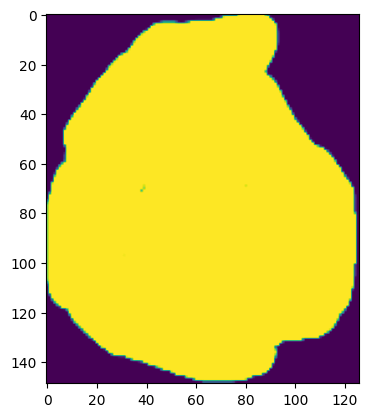

In [5]:
plt.imshow(get_cropped(gt))

In [108]:
%%timeit
def asymmetry_score_fully_rotated(img, n_steps: int = 10):
    """Rotates images step times around axis, and computes overlapping percentage
    Best score: 1, worst score: 0. Insert cropped image"""
    if (n_steps <  1 or n_steps > 180):
        raise Exception('Amount of steps of range [1, 180]')

    #img = get_cropped(img)
    sum_of_overlapping_areas = 0
    total_area = np.sum(img)*n_steps
    step_size = math.ceil(180 / n_steps)
    
    for angle in range(0, 180, step_size):
        
        rotated_mask = rotate(img, angle, resize=True)
        # There is no need to crop the image to boundary boxes, 
        # because the center remains in the middle.
        middle_column = rotated_mask.shape[1] // 2
        left_half = rotated_mask[:, :middle_column]
        flipped_right_half = flip(rotated_mask[:, -middle_column:])
        
        overlap = left_half * flipped_right_half
        
        overlapping_area = np.sum(overlap)
        sum_of_overlapping_areas += overlapping_area
        
    score = (2*sum_of_overlapping_areas / total_area) # need to account for both halves
    return score
asymmetry_score_fully_rotated(gt, 180)

665 ms ± 22.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [109]:
%%timeit
def asymmetry_score_one_max_rotated(img):
    """Returns maximum overlap for any possible axis.
    Best score: 1, worst score: 0."""

    `#img = get_cropped(img)
    max_overlapping_area = 0
    total_area = np.sum(img)
    step_size = 1
    
    for angle in range(0, 180, step_size):
        
        rotated_mask = rotate(img, angle, resize=True)
        # There is no need to crop the image to boundary boxes, 
        # because the center remains in the middle.
        middle_column = rotated_mask.shape[1] // 2
        left_half = rotated_mask[:, :middle_column]
        flipped_right_half = flip(rotated_mask[:, -middle_column:])
        
        overlap = left_half * flipped_right_half
        
        overlapping_area = np.sum(overlap)
        if (overlapping_area > max_overlapping_area):
            max_overlapping_area = overlapping_area
        
    return 2*max_overlapping_area / total_area # need to account for both halves
asymmetry_score_one_max_rotated(gt)

672 ms ± 16.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [110]:
%%timeit
def asymmetry_score_major_minor_overlap(img):
    """Finds the axis yielding highest overlap and treats it as major axis. Return summed percentage overlap of minor and major
    axes.
    Best score: 1, worst score: 0"""

    #img = get_cropped(img)
    major_max_overlapping_area = 0
    minor_overlapping_area = 0
    total_area = np.sum(img)
    step_size = 1
    
    for angle in range(0, 180, step_size):
        
        rotated_mask = rotate(img, angle, resize=True)
        # There is no need to crop the image to boundary boxes, 
        # because the center remains in the middle.
        middle_column = rotated_mask.shape[1] // 2
        left_half = rotated_mask[:, :middle_column]
        flipped_right_half = flip(rotated_mask[:, -middle_column:])
        
        major_overlap = left_half * flipped_right_half

        major_overlapping_area = np.sum(major_overlap)
        if (major_overlapping_area > major_max_overlapping_area):
            major_max_overlapping_area = major_overlapping_area
            
            middle_row = rotated_mask.shape[0] // 2
            
            top_half = rotated_mask[:middle_row, :]
            flipped_bottom_half = np.flipud(rotated_mask[-middle_row:, :])
            
            minor_overlap = top_half * flipped_bottom_half
            minor_overlapping_area = np.sum(minor_overlap)
        
     # need to account for both halves
    return (major_max_overlapping_area+minor_overlapping_area) / total_area
asymmetry_score_major_minor_overlap(gt)

665 ms ± 19.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


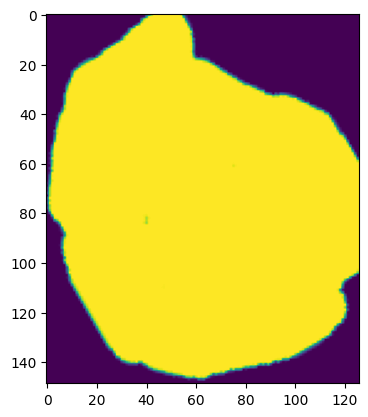

In [7]:
gt=get_cropped(gt)
plt.imshow(rotate(gt, 30))

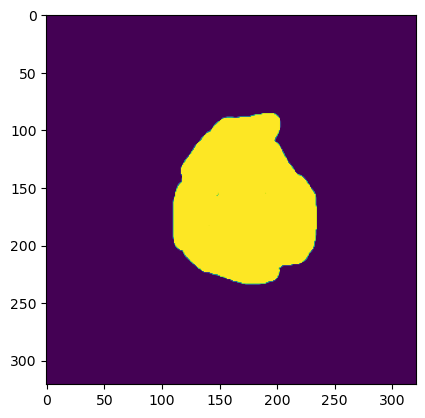

In [10]:
plt.imshow(gt)

In [111]:
%%timeit
def asymmetry_classic(img):
    """ Finds major axis using minimum bounding box methods and return combined overlap percentage"""
    initial_bounding_box = get_cropped(img, padding=0)
    # Lexographic order

    
    min_bounding_box = initial_bounding_box
    min_bounding_box_size = np.size(initial_bounding_box)
    i=0
    total_area = np.sum(initial_bounding_box)
    #print(min_bounding_box_size)
    
    for angle in range(0, 180, 1):
        
        rotated_mask = rotate(initial_bounding_box, angle, resize=True)
        bounding_box = get_cropped(rotated_mask, padding=0)
        bounding_box_size = np.size(bounding_box)
        #print(f'step {i} size {bounding_box_size} angle {angle}')
        i+=1
        if(min_bounding_box_size > bounding_box_size):
            min_bounding_box_size = bounding_box_size
            min_bounding_box = bounding_box
            #print(f'hit')
    
    if (min_bounding_box.shape[0] > min_bounding_box.shape[1]):
    # Use vertical axis as symmetry axis
        middle_column = min_bounding_box.shape[1] // 2
        left_half = min_bounding_box[:, :middle_column]
        flipped_right_half = np.fliplr(min_bounding_box[:, -middle_column:])
        overlap = left_half * flipped_right_half
    else:
    # Use horizontal axis as symmetry axis
        middle_row = min_bounding_box.shape[0] // 2  
        top_half = min_bounding_box[:middle_row, :]
        flipped_bottom_half = np.flipud(min_bounding_box[-middle_row:, :])  
        overlap = top_half * flipped_bottom_half
    
    overlapping_area = np.sum(overlap)
    score = (2*overlapping_area / total_area)
    
    return score
asymmetry_classic(gt)

727 ms ± 39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [104]:
def asymmetry_4_fold(img):
    pass

In [ ]:
def asymmetry_class_major_minor(img):
    pass

In [ ]:
def asymmetry_score_max_rotated(img):
    pass

In [ ]:
cr = get_cropped(gt)

plt.imshow(cr)

# WOrkshop below - no important. Above is ready code.

In [ ]:
img = cr
angle = 0
rotated_mask = rotate(img, angle, True)
# There is no need to crop the image to boundary boxes, 
# because the center remains in the middle
# but we are doing it, because I think it should speed up the process.
middle_column = rotated_mask.shape[1] // 2
left_half = rotated_mask[:, :middle_column]
flipped_right_half = flip(rotated_mask[:, -middle_column:])
overlap = left_half * flipped_right_half
# (left_half - rotated_area) + (flipped_right_half - rotated_area)
nonoverlapping_area = np.sum(left_half)+np.sum(flipped_right_half)-2*np.sum(overlap)
#sum_of_nonoverlapping_areas += nonoverlapping_area

plt.imshow(rotated_mask)

In [ ]:
plt.imshow(flipped_right_half - overlap)

In [ ]:
plt.imshow(flipped_right_half-overlap)